# Querying the TOM's database directly

For this to work, you must have an account on the DESC TOM.  If you need one and don't have one, contact Rob Knop (e.g. on Slack).

The interfaces below are based on python `requests` and `psycopg2` (for connecting to a PostgreSQL database).  Hopefully the examples will make clear everything you need, but some of this will be more obvious if you're familiar with those two things.

## Overview

The postgres database behind the DESC TOM is not externally available.  You may be able to get what you need by using the various REST interfaces the DESC TOM provides.  For a couple of examples:
* https://github.com/LSSTDESC/elasticc_metrics/blob/main/elasticc2_rest_metric_demo.ipynb for querying ELAsTiCC2 metrics
* https://github.com/LSSTDESC/tom_desc?tab=readme-ov-file#elasticc2spec for getting information about hot transients, requested spectra, and for pushing information about spectra you've taken.

If you need to access the SQL database directly, there are two web APIs, one for fast queries, one for slow queries.

## Fast Queries

For fast queries, you can use the API endpoint `db/runsqlquery/`.  You POST to this URL with the query you want to run in the POST data, and get back JSON including the results of your query.  This is documented with examples below.

## Slow Queries

The web proxy to the TOM will time out if a request takes more than 5 minutes.  So, if your SQL query is going to run more than a couple of minutes, the `db/runsqlquery/` interface won't work.  (ELAsTiCC2 has 990 million forced source datapoints and 380 million broker classification messages, so all it takes is the right table join and your query can take minutes and minutes... or more.)

To handle this, there's another interface that let's you submit a query (or a series of queries).  They will all one in one transaction, so you can do things like create temporary tables with these queries.  After submitting the query, you'll get back a query id, which you send to a couple of different web API endpoints to check the status of your query, and (if it's done) to get the results.  On the back end, there is a process that will run these slow queries.  (At the moment, there's only a single thread running those queries, but in the future I will make this multi-threaded so one person submitting a 3-day query doesn't block everybody else.)

This second interface is also documented with examples below.

In [1]:
%matplotlib inline
import sys
import os
import io
import math
import requests
import datetime
import json
import time
import pandas
import matplotlib.pyplot

from tom_client import TomClient

# Connecting to the TOM

To use either fast query or slow query interface, you need to connect to the DESC TOM.  You could accomplish this entirely using the python `requests` module, but there are some annoying things that django (the framework that the TOM works on) wants to see in headers.  To this end, there is a python module [`tom_client.py`](https://github.com/LSSTDESC/tom_desc/blob/main/tom_client.py) that takes care of this stuff.

Here, we create a variable `tomclient` that will log us into the TOM, and that we will use for the rest of the script to communicate with the TOM.

__Note__ : you will need to edit the next cell for your own TOM username and password.  (Read the comments.)

In [2]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-2.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)

# username = "root"
# passwordfile = "tom_root_passwd"
username = "rknop"
passwordfile = "tom_rknop_passwd"
with open( os.path.join( os.getenv("HOME"), "secrets", passwordfile ) ) as ifp:
    password = ifp.readline().strip()
    
# I could also have skipped the previous line and just done
#   tomclient = TomClient( url=url, username=username,
#                          passwordfile=os.path.join( os.getenv('HOME'), "secrets", "tom_rknop_passwd" ) )

tomclient = TomClient( url=url, username=username, password=password )

# The Fast Query Interface

If your query is going to take less than a couple of minutes, this is the one to use.  To run it, you send POST data to the endpoint `db/runsqlquery` on the DESC TOM.  The POST data should be a JSON encoded dictionary with keys:
* `query`: str or list of str.  The SQL query to run, or a list of queries to run in order in a single transaction.
* `subdict`: dict, list of dict, or None (default).  You can include `%(varname)s` in your SQL query, where `varname` can be any string.  Then, in your subdict, you should have `varname` as a key, and the value is what should be substituted into the query.  (These are as used in  the [psycopg2 cursor](https://www.psycopg.org/docs/cursor.html) "execute" method.)

You should practice good SQL hygiene and make sure to use `subdict` to interpolate any calculated or user-inputted parameters.  However, don't worry too much; unless Rob screwed up horribly, the back-end uses a read-only postgres user, so you won't be able to [Bobby Tables](https://xkcd.com/327/) the database.  (Note that even though it's a read-only user, you _can_ still create temporary tables.)

If all is well, the HTTP response you get from posting to that URL will have a status code of 200 (successful response).  If it's something else, it means that something went wrong, perhaps a timeout, perhaps something wrong server-side.  If everything worked server-side, but your SQL had an error in it, you should still get an HTTP status code response of 200.

The response body will be JSON encoded; you can extract this as a dictionary by calling the `json()` method of the response object.  One key of the dictionary will be `status`; if the value is `ok`, then there will be a second key `rows`, whose value is an array of dictionaries holding the results of your query (or of the last query, if you submitted a list).  If `status` is `error`, then something went wrong, almost certainly an error in your SQL.  In this case, look at the value of the `error` key in the dictionary to get an error message.  This is shown below; first, we define a boilerplate function that does all of the error parsing, so that we don't have to redo that every time we send a new query.

In [3]:
# This function effectively pushes a cursor.execute( query, subdict ) through
# the web API, returning the corresponding cursor.fetchrows().
#
# You can just post the SQL directly to tomclient.post(), sending 
# a dict in the postdata with keys "query" and "subdict".  The purpose
# of this function is to do some boilerplate error checking.
#
# You can pass multiple queries, in which case query should
# be a list of strings and subdict should be a list of dicts.
# You will get back the rows from the last query.  (This is
# how you would create temporary tables, for instance.)
#
# Depends on global variable tomclient

def run_query( query, subdict=None ):
    sendjson = { 'query': query }
    if subdict is not None:
        sendjson['subdict'] = subdict
    result = tomclient.post( 'db/runsqlquery/', json=sendjson )
    if ( result.status_code != 200 ):
        raise RuntimeError( f"Got http status {result.status_code}" )
    data = json.loads( result.text )
    if ( 'status' in data ) and ( data['status'] == 'error' ):
        sys.stderr.write( f"ERROR: {data['error']}" )
        return []
    elif ( 'status' not in data ) or ( data['status'] != 'ok' ):
        raise RuntimeError( f"Got unexpected response: {data}" )
    return data['rows']


In [4]:
# Example: look at the contents of the elasticc_gentypeofclassid table
# (That's the table that you would use if you have a gentype in order
# to figure out what classId a broker should supply for it.)
#
query = 'SELECT * FROM elasticc2_gentypeofclassid'
rows = run_query( query )
print( f'classId   gentype    description' )
print( '---------------------------------' )
for row in rows:
    print( f'{row["classid"]:7d}   '
           f'{"None" if row["gentype"] is None else str(row["gentype"]):>7s}    '
           f'{row["description"]}' )

classId   gentype    description
---------------------------------
      0      None    Meta
    100      None    Meta/Other
    200      None    Residual
    300      None    NotClassified
   1000      None    Static
   1100      None    Static/Other
   2000      None    Variable
   2100      None    Variable/Other
   2200      None    Non-Recurring
   2210      None    Non-Recurring/Other
   2220      None    SN-like
   2221      None    SN-like/Other
   2222        10    Ia
   2223        20    Ib/c
   2223        21    Ib/c
   2223        25    Ib/c
   2223        26    Ib/c
   2223        27    Ib/c
   2224        30    II
   2224        31    II
   2224        32    II
   2224        35    II
   2224        36    II
   2224        37    II
   2225        12    Iax
   2226        11    91bg
   2230      None    Fast
   2231      None    Fast/Other
   2232        50    KN
   2232        51    KN
   2233        82    M-dwarf Flare
   2234        84    Dwarf Novae
   2235        87  

In [5]:
# example: look at the contents of the classidofgentype table
# (That's the table you would use given a classId from a broker
# to figure out which gentypes (there could be more than one)
# correspond to it.)
#
query = 'SELECT * FROM elasticc2_classidofgentype'
rows = run_query( query )
print( f'classId   gentype    exactmatch categorymatch broadmatch generalmatch description' )
print( '----------------------------------------------------------------------------------' )
for row in rows:
    print( f'{row["classid"]:7d}   '
           f'{"None" if row["gentype"] is None else str(row["gentype"]):>7s}    '
           f'{str(row["exactmatch"]):10s} '
           f'{str(row["categorymatch"]):13s} '
           f'{str(row["broadmatch"]):10s} '
           f'{str(row["generalmatch"]):12s} '
           f'{row["description"]}' )

classId   gentype    exactmatch categorymatch broadmatch generalmatch description
----------------------------------------------------------------------------------
   2000        10    False      False         True       False        Variable
   2000        11    False      False         True       False        Variable
   2000        12    False      False         True       False        Variable
   2000        20    False      False         True       False        Variable
   2000        21    False      False         True       False        Variable
   2000        25    False      False         True       False        Variable
   2000        26    False      False         True       False        Variable
   2000        27    False      False         True       False        Variable
   2000        30    False      False         True       False        Variable
   2000        31    False      False         True       False        Variable
   2000        32    False      False        

In [6]:
# Example: we want to look at a SNIa lightcurve.  Pick out a SNIa from the truth table
# that has at least 5 detections.
query = ( 'SELECT diaobject_id,ndets FROM '
          ' ( SELECT ot.diaobject_id,COUNT(s.diasource_id) AS ndets FROM elasticc2_diaobjecttruth ot '
          '   INNER JOIN elasticc2_diasource s ON ot.diaobject_id=s.diaobject_id '
          '   INNER JOIN elasticc2_ppdbalert a ON s.diasource_id=a.diasource_id '
          '   WHERE a.alertsenttimestamp IS NOT NULL '
          '     AND ot.gentype=10 '
          '   GROUP BY ot.diaobject_id ) subq '
          '   WHERE ndets > 5 LIMIT 10 ' )
t0 = time.perf_counter()
objlist = run_query( query )
t1 = time.perf_counter()
sys.stderr.write( f"Request took {t1-t0:.2f} seconds" ) 
objlist

Request took 0.05 seconds

[{'diaobject_id': 1000065, 'ndets': 15},
 {'diaobject_id': 1000154, 'ndets': 21},
 {'diaobject_id': 1000720, 'ndets': 34},
 {'diaobject_id': 1000755, 'ndets': 6},
 {'diaobject_id': 1001012, 'ndets': 32},
 {'diaobject_id': 1001015, 'ndets': 12},
 {'diaobject_id': 1001227, 'ndets': 23},
 {'diaobject_id': 1001305, 'ndets': 15},
 {'diaobject_id': 1001572, 'ndets': 7},
 {'diaobject_id': 1001760, 'ndets': 11}]

In [7]:
# I like the look of the 3rd one I got when I ran this query so let's get that one's lightcurve.
#
# Get the lightcurve that would have been in the most recent alert that's been sent.  To do that:
# * Find the latest alert that has alertSentTimestamp that's not NULL.
# * Find the first alert for that object
# * Return everything in diaForcedSource that is between (first alert - 30 days) and (latest alert)
#
# (Note that because elasticc2 is over, all alerts were sent, so this is kind of gratuitous; I
# could have just gotten all the points.  But, for demo purposes...)

objid = objlist[2]['diaobject_id']
query = ( 'SELECT midpointtai,filtername,psflux,psfluxerr FROM elasticc2_diaforcedsource '
          'WHERE diaobject_id=%(objid)s '
          'AND midPointTai >= ( SELECT midpointtai-30 FROM elasticc2_diasource '
          '                     WHERE diaobject_id=%(objid)s '
          '                     ORDER BY midpointtai LIMIT 1 ) '
          'AND midPointTai <= ( SELECT midpointtai FROM elasticc2_diasource s '
          '                     INNER JOIN elasticc2_ppdbalert a ON s.diasource_id=a.diasource_id '
          '                     WHERE a.alertsenttimestamp IS NOT NULL AND s.diaobject_id=%(objid)s'
          '                     ORDER BY s.midpointtai DESC LIMIT 1 ) ' )
t0 = time.perf_counter()
rows = run_query( query, { 'objid': objid } )
t1 = time.perf_counter()
sys.stderr.write( f"Request took {t1-t0:.2f} seconds." )
print( f"Got {len(rows)} forced photometry points." )

Got 75 forced photometry points.


Request took 0.05 seconds.

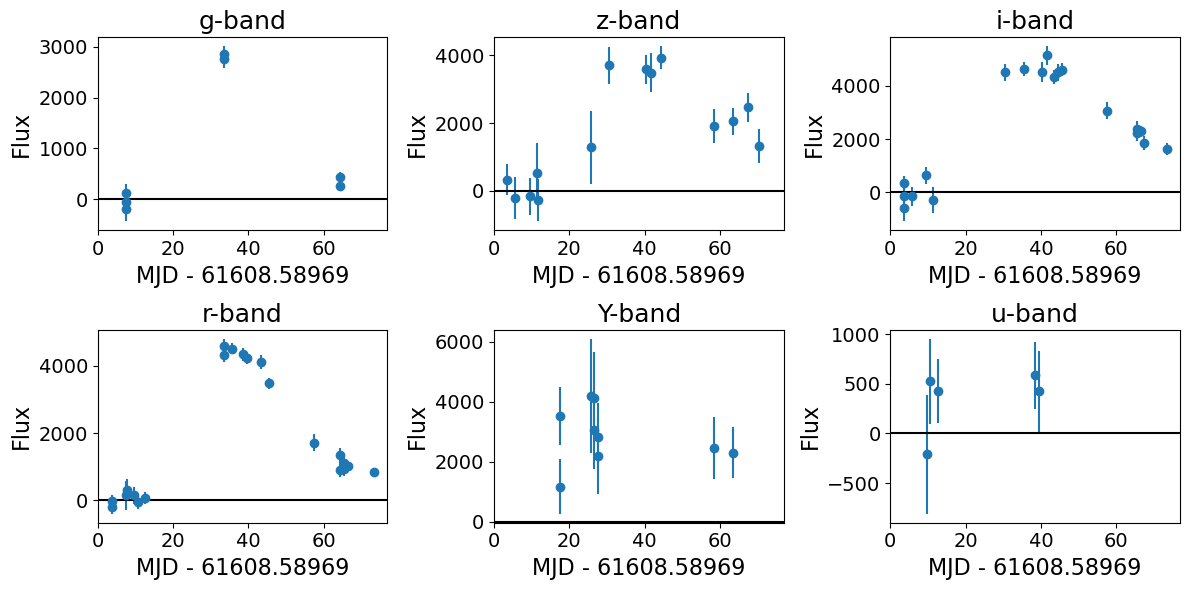

In [8]:
# Plot!
df = pandas.DataFrame( rows )
filters = df['filtername'].unique()
mint = df['midpointtai'].min()
maxt = df['midpointtai'].max()
dt = maxt-mint
mint -= 0.05*dt
maxt += 0.05*dt
ncols = 3
nrows = math.ceil( len(filters) / ncols )
fig = matplotlib.pyplot.figure( figsize=(12,3*nrows), tight_layout=True )
for i, filter in enumerate(filters):
    subdf = df[ df['filtername'] == filter ]
    ax = fig.add_subplot( nrows, ncols, i+1 )
    ax.errorbar( subdf['midpointtai']-mint, subdf['psflux'], subdf['psfluxerr'], linestyle='None', marker='o' )
    ax.set_title( f'{filter}-band', fontsize=18 )
    ax.set_xlabel( f'MJD - {mint}', fontsize=16 )
    ax.set_ylabel( 'Flux', fontsize=16 )
    ax.tick_params( 'both', labelsize=14 )
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
        ax.set_ylim( 0, ymax )
    else:
        ax.axhline( color='black' )
    ax.set_xlim( 0, maxt-mint )
fig.show()
    

In [9]:
# Gratuitous multiple query example

queries = [ 'SELECT a.alert_id,a.diasource_id,a.diaobject_id,s.diaobject_id AS indirect_object '
            'INTO TEMP TABLE gratuitous_table '
            'FROM elasticc2_ppdbalert a'
            '  INNER JOIN elasticc2_diasource s ON a.diasource_id=s.diasource_id '
            'LIMIT 100 '
           ,
            'SELECT * FROM pg_temp.gratuitous_table' ]
t0 = time.perf_counter()
rows = run_query( queries )
t1 = time.perf_counter()
sys.stderr.write( f"Request took {t1-t0:.2f} seconds\n" )
print( "alertId          diaSourceId       diaObjectId      indirect_object\n"
       "--------------------------------------------------------------------------" )
for row in rows:
    print( f"{row['alert_id']:16d} {row['diasource_id']:16d} {row['diaobject_id']:16d} {row['indirect_object']:16d}" )

alertId          diaSourceId       diaObjectId      indirect_object
--------------------------------------------------------------------------
  13521318000051   13521318000051        135213180        135213180
  13521318000068   13521318000068        135213180        135213180
  13521318000070   13521318000070        135213180        135213180
  13521318000074   13521318000074        135213180        135213180
  13521318000076   13521318000076        135213180        135213180
  13521318000081   13521318000081        135213180        135213180
  13521318000084   13521318000084        135213180        135213180
  13521318000093   13521318000093        135213180        135213180
  13521318000095   13521318000095        135213180        135213180
  13521318000099   13521318000099        135213180        135213180
  13521318000102   13521318000102        135213180        135213180
  13521318000113   13521318000113        135213180        135213180
   4768919800101    4768919800101        

Request took 0.06 seconds


# The Slow Query Interface

The slow query interface is inevitably going to be less convenient to use.  The overview of how to use it is:

* POST to API endpoint `db/submitsqlquery/` to submit your query (or queries) and get an id for your query.  Save this id, because it's the only way to get the results of your query later!  (At the moment, there's no interface to see all queries you've submitted.  I will hopefully add that at some point.)
* Wait
* POST to API endpoint `checksqlquery/<queryid>/` to see if your query is done.  If so, go on.  If not, wait, and repeat this step.
* POST to API endpoint `getsqlqueryresults/<queryid>/` to get the results of your query

(Notice the slashes at the ends of the URLs; that's another annoying djangoism.)


## Submitting a query

The POST data to `db/submitsqlquery/` must be a JSON-encoded dictionary with keys:
* `query: str` : the query to run, with possible `%(varname)s` variables to be interpolated.  (See the docs on the fast query interface above.)
* `queries: list of str` : a list of queries to run.  You must include exactly one of `query` or `queries`.
* `subdict: dict` : the substitution dictionary to go with `query`.  Optional, if you have no variables to substitute.
* `subdicts: list of dict` : the substitution dictionaries to go with `queries`.  Optional, if none of your queries have any variables to interpolate.  If specified, the length of the list must match the length of the list in `queries`.
* `format: str` : the format you will want your data returned in; one of `csv`, `pandas`, or `numpy`.  If `csv`, you will get back text data in csv format (with actual commas separating the fields).  If `pandas`, you will get back a binary blob that is a pickled pandas object.  If `numpy`, you will get back an error, because that format isn't implemented yet.  If you don't specify `format`, it will default to `csv` (the least efficient, but most likely to be readable, format).

If all is well, the response you get will have status code 200, and the body of the response will be a JSON-encoded dictionary; call that `resdict`.  (You can get `resdict` with something like `resdict=resp.json()`, if `resp` is the thing returned by your `TomClient.post()` call.)  If `resdict['status']` is `ok`, then `resdict['queryid']` has the id of your query.  Save this!  If you lose it, you won't be able to get your query results.  If `resdict['status']` is `error`, then look at `resdict['error']` to see if there's anything helpful there.

For example:


In [10]:
queryid = None

res = tomclient.post( 'db/submitsqlquery/', json={ 'query': 'SELECT * FROM elasticc2_ppdbdiaobject' } )
if res.status_code != 200:
    sys.stderr.write( f"ERROR, got status {res.status_code}\n" )
elif res.headers['Content-Type'][:16] != 'application/json':
    sys.stderr.write( f"ERROR, didn't get json, got {res.headers['Content-Type']}" )
else:
    data = res.json()
    if 'status' not in data.keys():
        sys.stderr.write( f"Unexpected response: {data}\n" )
    elif data['status'] == 'error':
        sys.stderr.write( f"Got an error: {data['error']}\n" )
    elif data['status'] != 'ok':
        sys.stderr.write( f"status is {data['status']} and I don't know how to cope.\n" )
    else:
        queryid = data['queryid']
        print( f"Submitted query {queryid}" )


Submitted query 7b3c111a-8b0b-4e6c-90ba-0934fea35458


## Checking the status of your query

POST to `db/checksqlquery/<queryid>/`, where `<queryid>` is the id you got back above.  If all is well, the response will have status code 200, and the response body will be a JSON-encoded dictionary, call it `resdict`.  `resdict['status']` will have one of the following values:
* `queued` : your query is waiting to run
* `started` : your query has started, but not finished
* `finished` : your query is finished
* `error` : something went wrong, perhaps an SQL error.  Look at `resdict['error']`, there may be something helpful there.

Repeat this until you get a finished or error status.  Don't do this in a rapid `while` loop!  You shouldn't post to this API more than once a minute.  The backend process that actually performs the queries only looks for things to do once a minute, so in the best case it will take up to a minute for your query to start.  Once your query has started, if you expect it to finish in less than a minute or so, you would have been better off using the fast query interface described above.  Really, what you should so is submit your query, and then go get a cup of coffee, or sleep for the night, or go on a vacation to Paris.  When you're back, check to see if the query is done.  (Then, fix the typo in your SQL and repeat the process, including the vacation.)

If after a long time your query is not started, it's possible that the back-end process that actually makes these queries is not running.  There's no easy way to diagnose that other than talking to Rob (e.g. on Slack).  It's also possible that somebody else has submitted a really long query, and your query is waiting.  At the moment, only a single query can run at once, but if there are problems, I'll run multiple processes so we can have multiple queries running at once.

If your query has started, but not finished, nor errored out, it's possible that something went wrong that failed to generate an error message; you should only suspect this if there has been ample time to run your query (which could be a lot of time).  There's no easy way to diagnose this other than bugging Rob.


In [13]:
# Check the query status to see if the query is done.  Keep rerunning
# this until you see the query is done.

res = tomclient.post( f'db/checksqlquery/{queryid}/' )
if res.status_code != 200:
    sys.stderr.write( f"ERROR, got status {res.status_code}\n" )
else:
    data = res.json()
    status = data['status']
    
    if status == 'error':
        print( f"Got error response\n{json.dumps(data,indent=2)}" )
    else:
        submittime = data['submitted']
        queries = data['queries']
        subdicts = data['subdicts']

        print( f"Query was submitted: {submittime}" )
        print( f"Sequence of queries to run:" )
        for q, s in zip( queries, subdicts ):
            print( f"    {q}   {s}" )
        print( f"Status of query is: {status}" )

        if ( status == 'started' ) or ( status == 'finished' ):
            print( f"Query started: {data['started']}" )
        if status == "finished":
            print( f"Query finished: {data['finished']}" )


Query was submitted: 2024-04-25T16:55:27.539971+00:00
Sequence of queries to run:
    SELECT * FROM elasticc2_ppdbdiaobject   {}
Status of query is: finished
Query started: 2024-04-25T16:55:42.252463+00:00
Query finished: 2024-04-25T17:00:34.672105+00:00


## Reading the results

POST to URL `db/getsqlqueryresults/<queryid>/`.  If things go wrong, the response will have a status code of 500 (probably).  If the status code is 200, you'll get back either `text/csv` with the contents of the CSV file in `resp.text` (assuming `resp` is the variable where you stored the return value of your call to TomClient.post()), or `application/octest-stream` with a binary blob in `resp.contents`.  What you get depends on the format you asked for when you submitted the query.

If you get back a `csv`, you can make an `io.StringIO` object, feeding it `resp.text`.  Pass that to `pandas.read_csv`, and you'll get a DataFrame.  This is what happens in the example below.

If you get back a binary blob, and you asked for pandas format, then you could initialize a `io.BytesIO` object with `resp.content`.  Feed that `BytesIO` object to `pandas.read_pickle()`, and viola, you should have a DataFrame with the results of your query.

(It's possible that the pickle read will fail if the pandas/python version you're running is sufficiently differet from the one running on the TOM server.)


In [14]:
# If the query is finished, we can get the results.  In this case, we asked
#  for a csv file, but it's probably more efficient to ask for a pickled
#  pandas file.

sys.stderr.write( f"Posting at {datetime.datetime.now().isoformat()}\n" )
res = tomclient.post( f'db/getsqlqueryresults/{queryid}/' )
if res.status_code != 200:
    sys.stderr.write( f"ERROR, got status {res.status_code}; look at res.text" )
else:
    sys.stderr.write( f"Importing at {datetime.datetime.now().isoformat()}\n" )
    sio = io.StringIO( res.text )
    df = pandas.read_csv( sio )
    # Free up memory
    sio = None
    res = None
    display(df)
sys.stderr.write( f"Done at {datetime.datetime.now().isoformat()}\n" )

Posting at 2024-04-25T10:10:43.406423
Importing at 2024-04-25T10:10:56.940814


,Unnamed: 0,diaobject_id,simversion,ra,decl,mwebv,mwebv_err,z_final,z_final_err,hostgal_ellipticity,...,hostgal2_ra,hostgal2_dec,hostgal2_snsep,hostgal2_magerr_u,hostgal2_magerr_g,hostgal2_magerr_r,hostgal2_magerr_i,hostgal2_magerr_z,hostgal2_magerr_y,isddf
0,0,47689198,20231017,309.075402,-51.439603,0.023297,0.001165,0.021997,0.06511,0.3727,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
1,1,135213180,20231017,190.347900,-11.042899,0.037242,0.001862,0.023652,0.06511,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
2,2,4801027,20231017,200.443806,-15.984347,0.060404,0.003020,0.023543,0.06511,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
3,3,89581103,20231017,348.996243,-57.294989,0.014253,0.000713,1.390210,1.38814,0.6308,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
4,4,46630002,20231017,270.310224,-29.040784,0.794051,0.039703,0.576428,0.60311,0.4358,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119317,4119317,52330434,20231017,62.112554,-17.085374,0.019704,0.000985,-9.000000,-9.00000,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
4119318,4119318,30275730,20231017,60.872780,-8.803361,0.037803,0.001890,-9.000000,-9.00000,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
4119319,4119319,1660527,20231017,161.589301,-58.121086,0.846858,0.042343,-9.000000,-9.00000,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False
4119320,4119320,94612614,20231017,108.423938,-29.449632,0.141966,0.007098,-9.000000,-9.00000,-9999.0000,...,-999.0,-999.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,False


Done at 2024-04-25T10:11:26.431118


35